To Do List:

-do non-lightkurve periodogram (use scipy method)

-make iterable through entire folder of light curves

-download lightcurves to run on

-save into correct folder

-get period as just a list of variables

-put together list of features

-figure out what these fucking 'moments' are

-plot features against each other


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Reshape, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

import lightkurve as lc

import astropy
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.utils.data import get_pkg_data_filename

from datetime import datetime

In [2]:
"/Users/conta/UROP_Spring_2020/tessdata_lc_sector20_1000/tess2019357164649-s0020-0000000004132133-0165-s_lc.fits"

'/Users/conta/UROP_Spring_2020/tessdata_lc_sector20_1000/tess2019357164649-s0020-0000000004132133-0165-s_lc.fits'

In [49]:
#following https://github.com/spacetelescope/notebooks/blob/master/notebooks/MAST/TESS/beginner_how_to_use_lc/beginner_how_to_use_lc.ipynb

In [54]:
#now on my own data!
file = get_pkg_data_filename("/Users/conta/UROP_Spring_2020/tessdata_lc_sector20_1000/tess2019357164649-s0020-0000000004132133-0165-s_lc.fits")
fits.info(file)
image_data = fits.getdata(file, ext=1)
print(image_data.shape)

Filename: \Users\conta\UROP_Spring_2020\tessdata_lc_sector20_1000\tess2019357164649-s0020-0000000004132133-0165-s_lc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  LIGHTCURVE    1 BinTableHDU    167   18954R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 13)   int32   
(18954,)


In [55]:
fits.getdata(file, ext=1).columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'SAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'PSF_CENTR1'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR1_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'PSF_CENTR2'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR2_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'MOM_CENTR1'; format = 'D'; u

In [57]:
with fits.open(file, mode="readonly") as hdulist:
    tess_bjds = hdulist[1].data['TIME']
    sap_fluxes = hdulist[1].data['SAP_FLUX']
    pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']

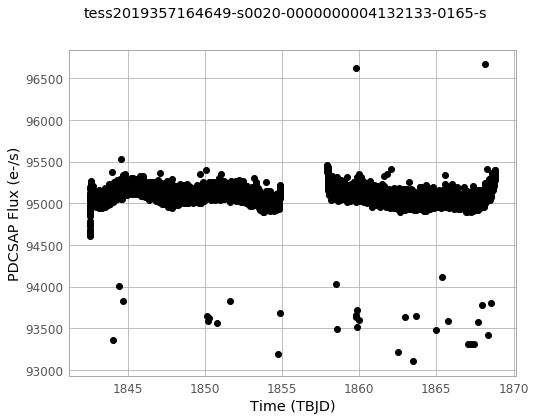

In [72]:
#plotting
# Start figure and axis.
fig, ax = plt.subplots()

# Plot the timeseries in black circles.
ax.plot(tess_bjds, pdcsap_fluxes, 'ko')

# label the axes and define a title for the figure.
fig.suptitle("tess2019357164649-s0020-0000000004132133-0165-s")
ax.set_ylabel("PDCSAP Flux (e-/s)")
ax.set_xlabel("Time (TBJD)")
#ax.set_xlim(1850,1850.5)
plt.show()

In [62]:
#must be a light curve object (currently a numpy array) in order to use the lightkurve periodogram func

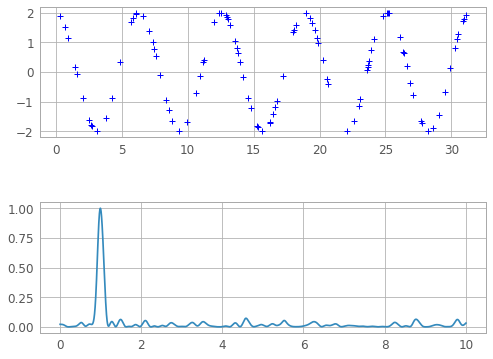

In [64]:
#from https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lombscargle.html
A = 2.
w = 1.
phi = 0.5 * np.pi
nin = 1000
nout = 100000
frac_points = 0.9 # Fraction of points to select

r = np.random.rand(nin)
x = np.linspace(0.01, 10*np.pi, nin)
x = x[r >= frac_points]

y = A * np.sin(w*x+phi)

f = np.linspace(0.01, 10, nout)

import scipy.signal as signal
pgram = signal.lombscargle(x, y, f, normalize=True)

#input data
plt.subplot(2, 1, 1)
plt.plot(x, y, 'b+')

#periodogram
plt.subplot(2, 1, 2)
plt.plot(f, pgram)
plt.show()

need to get rid of nans before running periodogram? or interpolate data? or append it?
get rid of data with big gaps between data points. interpolate short gaps. define those timescales.

use spatially local light curves to minimize scattered light issues. hwo to identify this?
astroquery for a specific CCD (query_region or criterion) for an ra/dec and then only take those. 

identifying systematics in TESS data? looking for quality = 1 (property)

are all tess lightcurves going to be periodic? or will some of them be duds? what does the LS look like if it isn't?
some will definitely be duds! and then the periodogram should look like a flat line or 0 frequencies, with some false bumpy bits

In [18]:
#borrowing largely from https://docs.lightkurve.org/tutorials/01-using-the-periodogram-class.html
filename = lc.open("/Users/conta/UROP_Spring_2020/tessdata_lc_sector20_1000/tess2019357164649-s0020-0000000004132133-0165-s_lc.fits")

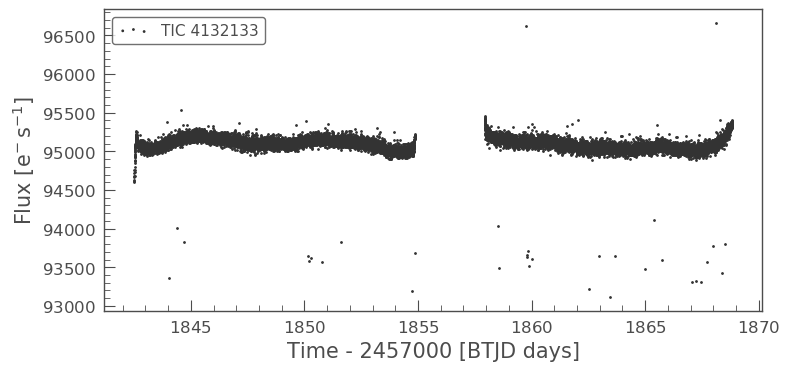

In [10]:
file_pdcsap = filename.PDCSAP_FLUX
file_pdcsap.scatter()

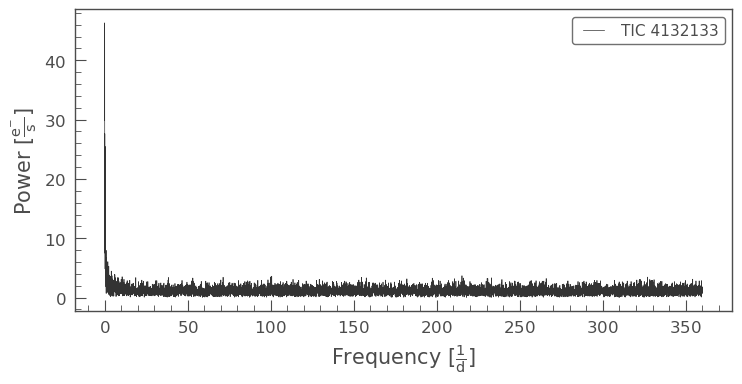

In [25]:
now = datetime.now()
timestamp = datetime.timestamp(now)
timestamp = str(timestamp)

pdcsap_clean = file_pdcsap.remove_nans()
periodogram = pdcsap_clean.to_periodogram(method='lombscargle',oversample_factor=1)
periodogram.plot()
plt.savefig(timestamp + "periodogram_freq.png")

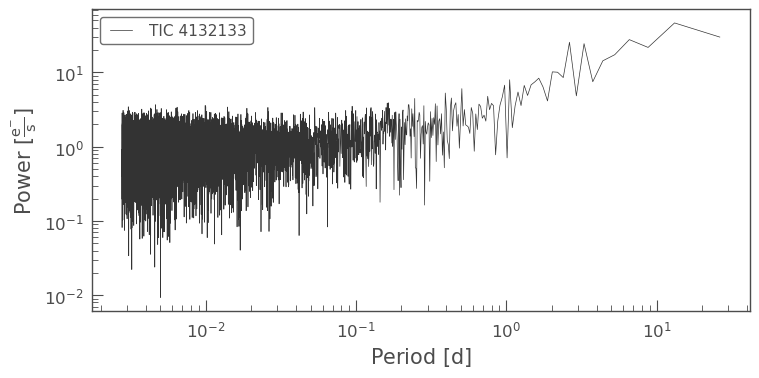

In [27]:
periodogram.plot(view='period', scale='log')
plt.savefig(timestamp + "periodogram_period.png")

In [21]:
periodogram.period
periodogram.period_at_max_power

<Quantity 13.15913288 d>